In [1]:
import torch
import torch.nn as nn
import torch.utils.data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Generating and visualising training data

In [2]:
def get_samples(num_of_points, random=True):
    train_data = torch.zeros((num_of_points, 2))
    if random:
        freq = np.random.uniform(1.2, 1.5)
    else:
        freq = 1
    signal_x = np.linspace(0,10, num_of_points)
    signal_y = np.array([np.sin(i*freq) for i in signal_x])
    train_data[:, 0] = torch.from_numpy(signal_x)
    train_data[:, 1] = torch.from_numpy(signal_y)
    
    return train_data

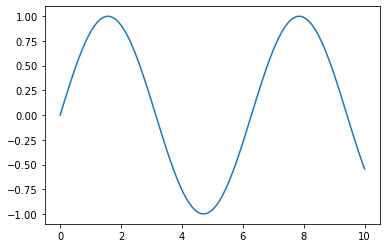

In [3]:
num_of_points = 100

train_data = get_samples(num_of_points, False)

plt.plot(train_data[:, 0], train_data[:, 1])

In [4]:
train_labels = torch.ones(num_of_points)
train_dataset = [(train_data[i], train_labels[i]) for i in range(num_of_points)]

In [5]:
batch_size = 10

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [6]:
print(train_loader)

### Defining models

In [7]:
class Discriminator(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, p=0.3):
        super().__init__()
        
       
        #layers
        self.hidden0 = nn.Sequential(
            nn.Linear(input_size, hidden_dim*4),
            nn.LeakyReLU(0.2),
            nn.Dropout(p)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(hidden_dim*4, hidden_dim*2),
            nn.LeakyReLU(0.2),
            nn.Dropout(p)
        )
        
        self.hidden2 = nn.Sequential(
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(p)
        )
        
        self.out = nn.Sequential(
            nn.Linear(hidden_dim, output_size),
            nn.Sigmoid()
        )
       
    
        
    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        out = self.out(x)
        return out

In [8]:
class Generator(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, p=0.3):
        super().__init__()
          
    #layers
        self.hidden0 = nn.Sequential(
            nn.Linear(input_size, hidden_dim//4),
            nn.ReLU(),
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(hidden_dim//4, hidden_dim//2),
            nn.ReLU(),
        )
        self.out = nn.Sequential(
            nn.Linear(hidden_dim//2, output_size),
        )
       
    
        
    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        out = self.out(x)
        return out

In [9]:
input_size = 2

d_output_size = 1
g_output_size = 2

hidden_dim = 64

In [10]:
D = Discriminator(input_size, d_output_size, hidden_dim)
G = Generator(input_size, g_output_size, hidden_dim)

In [11]:
print(D)

Discriminator(
  (hidden0): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
  )
  (hidden1): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
  )
  (hidden2): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
  )
  (out): Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
    (1): Sigmoid()
  )
)


In [12]:
print(G)

Generator(
  (hidden0): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
  )
  (hidden1): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU()
  )
  (out): Sequential(
    (0): Linear(in_features=32, out_features=2, bias=True)
  )
)


### Training

In [13]:
def loss_function(D_out, label):
    if label == 1:
        labels = torch.ones(batch_size, 1)
    else:
        labels = torch.zeros(batch_size, 1)
        
    criterion = nn.BCELoss()
    
    loss = criterion(D_out, labels)
    
    return loss


In [14]:
import torch.optim as optim

lr = 0.001

#Createing optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

In [15]:
num_epochs = 3000


losses = []


for epoch in range(num_epochs):
    for batch_i , (real_samples, _) in enumerate(train_loader):
    
        # Training the discriminator 
        # 1) with real samples
        
        d_optimizer.zero_grad()

        D_real_output = D(real_samples)

        d_real_loss = loss_function(D_real_output, 1)
        
        # 2) with fake samples

        latent_space_samples = torch.randn((batch_size, 2))
        
        fake_generated_samples = G(latent_space_samples)
        
        D_fake_output = D(fake_generated_samples)
        
        d_fake_loss = loss_function(D_fake_output, 0)
        
        #adding fake loss and real loss 
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        #Training the generator
        
        g_optimizer.zero_grad()
        
        latent_space_samples = torch.randn((batch_size, 2))
        
        fake_generated_samples = G(latent_space_samples)
        
        #computing discriminator losses on fake samples

        D_fake_output = D(fake_generated_samples)

        g_loss = loss_function(D_fake_output, 1)

        g_loss.backward()

        g_optimizer.step()
        
        if epoch % 50 == 0 and batch_i == 4:
            print(f"Epoch {epoch}, d_loss: {d_loss.item()}, g_loss: {g_loss.item()}")
            
    losses.append((d_loss.item(), g_loss.item()))
    
        

Epoch 0, d_loss: 0.8400230407714844, g_loss: 0.8105347752571106
Epoch 50, d_loss: 1.180121898651123, g_loss: 0.835675835609436
Epoch 100, d_loss: 1.419529914855957, g_loss: 0.7946504354476929
Epoch 150, d_loss: 1.261350393295288, g_loss: 0.8727604150772095
Epoch 200, d_loss: 1.3151016235351562, g_loss: 0.6821205615997314
Epoch 250, d_loss: 1.3606557846069336, g_loss: 0.6212108731269836
Epoch 300, d_loss: 1.2239048480987549, g_loss: 0.8158696889877319
Epoch 350, d_loss: 1.4602687358856201, g_loss: 0.9234715700149536
Epoch 400, d_loss: 1.3863022327423096, g_loss: 0.7573363780975342
Epoch 450, d_loss: 1.3162001371383667, g_loss: 0.747054934501648
Epoch 500, d_loss: 1.56196129322052, g_loss: 0.8044004440307617
Epoch 550, d_loss: 1.3730380535125732, g_loss: 0.7715426087379456
Epoch 600, d_loss: 1.3934974670410156, g_loss: 0.6945136785507202
Epoch 650, d_loss: 1.231344223022461, g_loss: 0.7297900915145874
Epoch 700, d_loss: 1.318149447441101, g_loss: 0.7236674427986145
Epoch 750, d_loss: 1.3

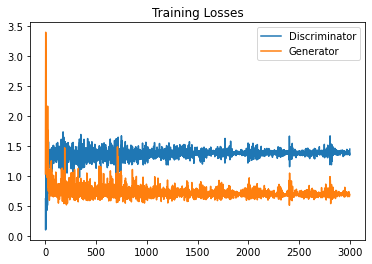

In [16]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()



### Generating sinusoid

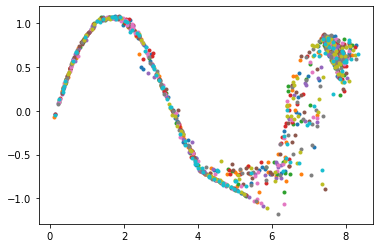

In [20]:
for i in range(10):
    sample_test_noise = torch.randn(num_of_points, 2)
    generated = G(sample_test_noise)
    generated = generated.detach()
    plt.plot(generated[:, 0], generated[:, 1], '.')